# Module 7: Feature Monitoring
**This notebook leverages AWS Glue DataBrew to implement Feature Monitoring of Offline Feature Groups.**

**Note:** Please set kernel to `Python 3 (Data Science)` and select instance to `ml.t3.medium`


---

## Contents

1. [Overview](##Overview)
2. [Feature Group Monitoring Preparation](#Feature-Group-Monitoring-Preparation)
3. [Run Feature Group Monitoring using DataBrew Profile Job](#Run-Feature-Group-Monitoring-using-DataBrew-Profile-Job)
4. [Visualisation of Feature Group statistics](#Visualisation-of-Feature-Group-statistics)
5. [Clean up](#Clean-Up)



## Overview

In previous module (`Module-1 Introduction to SageMaker Feature Store`), we demonstrated how to create multiple features groups inside a Amazon SageMaker Feature Store and ingest data into it.

In this notebook, we will illustrate how to implement feature monitoring using AWS Glue DataBrew to create feature statistics.

[AWS Glue DataBrew](https://aws.amazon.com/glue/features/databrew/) is a visual data preparation tool that helps you clean and normalize data without writing code. DataBrew also allows customers to specify which data quality statistics to auto-generate for datasets when running a profile job. This allows users to customize data profile statistics such as determining duplicate values, correlations, and outliers based on the nature and size of their datasets, and create a custom data profile overview with only the statistics that meet their needs.

We will cover the following aspects:

* Preparation step to Feature Monitoring
* Executing Feature Monitoring using a DataBrew Profile job to generate statistics for a feature group
* Extract statistics from profile job execution and persist to S3
* Additional visualisation of the feature group statistics

![Feature Monitoring Architecture](../images/feature_monitoring_architecture.png "Feature Monitoring Architecture")
---

## Setup

#### Imports

In [ ]:
%%capture
!pip install pyathena

In [1]:
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role
import sagemaker
import logging
import boto3
import pandas as pd
import time
import re
import os
import sys
from IPython.display import display, Markdown
from time import gmtime, strftime

#module containing utility functions for this notebook
import feature_monitoring_utils

In [2]:
logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [3]:
logger.info(f'Using SageMaker version: {sagemaker.__version__}')

Using SageMaker version: 2.49.1


#### Retrieve Feature Group

**Replace with the names of the Feature Groups created in Module 1 of the workshop.**

In [4]:
# Need to retreive FG names from previous FSCW notebooks
# Retreive FG names
# %store -r orders_feature_group_name
# %store -r orders_count

orders_feature_group_name = "fscw-orders-07-13-17-38"
orders_count = 100000

# Set up the results bucket location
results_bucket=sagemaker.Session().default_bucket() # You might change this for a different s3 bucket
results_key='aws-databrew-results/Offline-FS'


#### Update SageMaker Studio execution role 
If you are running this notebook in Amazon SageMaker Studio, the IAM role assumed by your Studio user needs permission to perform Glue and DataBrew operations. To provide this permission to the role, do the following.

1. Open the [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/).
2. Select Amazon SageMaker Studio and choose your user name.
3. Under **User summary**, copy just the name part of the execution role ARN 
5. Go to the [IAM console](https://console.aws.amazon.com/iam) and click on **Roles**. 
6. Find the role associated with your SageMaker Studio user
7. Under the Permissions tab, click **Attach policies** and add the following: **AWSGlueServiceRole**, **AWSGlueDataBrewFullAccessPolicy**, **AmazonAthenaFullAccess**
8. Under Trust relationships, click **Edit trust relationship** and add the following JSON,
```
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "sagemaker.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "glue.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "databrew.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}
```
 

## Feature Group Monitoring Preparation

This function will execute a few steps to prepare the data before running DataBrew profiling job and generate statistics.

* Create Snapshot of a Feature Group from Offline Feature Store (before creating using DataBrew profiling capability, we need to create a snapshot of the Feature from the Offline Feature Store which only keeps the latest version of a feature and removes records marked as to be deleted)
* Crawl the Snapshot table (the newly created table needs to be crawled to be accessible by DataBrew. The following function will create an AWS Glue Crawler, start the crawler)
* Create AWS Glue DataBrew dataset
* Create AWS Glue DataBrew Profile Job

In [5]:
response_brew_prep = feature_monitoring_utils.feature_monitoring_prep(
    orders_feature_group_name, 
    results_bucket, 
    results_key
)

Feature Group S3 URL: s3://sagemaker-eu-west-1-353515212017/sagemaker-feature-store/353515212017/sagemaker/eu-west-1/offline-store/fscw-orders-07-13-17-38-1626198069
Feature Group Table Name: fscw-orders-07-13-17-38-1626198069
[]
Total execution time in millis:  13982
Total data scanned in bytes:  223615643
Table created successfully: fscw-orders-07-13-17-38-1626198069-ctas-temp
CSAT_FS_Products
FG_Products_07_13_17_38
OrdersFGPartition1
crawler-fscw-orders-08-19-20-06
feature_group_profile_csv
offline-fs-query-notebook
({'ResponseMetadata': {'RequestId': '53269040-f899-469f-94cc-31e63b3f4af9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 28 Sep 2021 08:16:05 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '53269040-f899-469f-94cc-31e63b3f4af9'}, 'RetryAttempts': 0}}, 'fscw-orders-07-13-17-38-1626198069-ctas-temp-crawler')
state_previous:= None
current state= READY
Crawling fscw-orders-07-13-17-38-162619

## Run Feature Group Monitoring using DataBrew Profile Job

This section will run an AWS Glue DataBrew Profile (defined in the previous section).

#### Launch DataBrew Profile Job

In [14]:
# Call the main profile execution function
response_brew_job = feature_monitoring_utils.feature_monitoring_run(
    orders_feature_group_name,
    verbose=False
)

Running DataBrew Profiling Job
......................



#### Retrieve Link to DataBrew Profile Job Visualizations

Users can access the statistics for a particular job run using the AWS DataBrew Console UI.  The code below retrieves the URL link.
![Feature Group Tag](../images/databrew_visualization.png "DataBrew Visualization")

This link is also added as tag to the Feature Group (as per the picture below).

![Feature Group Tag](../images/feature_group_tags.png "Feature Group Tag")


In [15]:
# Display the Report S3 location
databrew_profile_console_url = response_brew_job[2]
brew_results_s3 = response_brew_job[4]
print("Report is available at the following S3 location:\n" + brew_results_s3 + "\n")

# Display the DataBrew link
print("Please click on the link below to access visulizations in Glue DataBrew console:")
databrew_link = f'[DataBrew Profile Job Visualizations]({databrew_profile_console_url})'
display(Markdown(databrew_link))

Report is available at the following S3 location:
s3://sagemaker-eu-west-1-353515212017/aws-databrew-results/Offline-FS-reports/fscw-orders-07-13-17-38-dataset_9b60dbd6de8646652e9a4362790300abd7fa1285b2afa851e6f5a96be943dfd4.json

Please click on the link below to access visulizations in Glue DataBrew console:


[DataBrew Profile Job Visualizations](https://eu-west-1.console.aws.amazon.com/databrew/home?region=eu-west-1#dataset-details?dataset=fscw-orders-07-13-17-38-dataset&tab=profile-overview)

### Ingest more rows into the feature group to simulate feature drift

The CSV file used for the ingestion was previously generated in 1st module. 

If the correspondent CSV file is not present at *../data/transformed/* folder, you will have to generate it by launching this notebook *m1_nb0_prepare_datasets.ipynb* from 1st module

In [7]:
# Provide the path to input CVS file
csv_path = '.././data/transformed/orders.csv'
nbrows = 0
nb_runs = 2 # Number of reports we want to generate
nb_sample = int(orders_count*0.25/nb_runs)

# Ingest rows and execute profile job
for x in range(nb_runs):
    nbrows = nbrows + nb_sample
    # Ingest rows into FG from CSV file
    feature_monitoring_utils.ingest_rows_fg(orders_feature_group_name, csv_path, nbrows=nbrows)
    # Call the main profile execution function
    resp_job = feature_monitoring_utils.feature_monitoring_run(orders_feature_group_name, verbose=False)

Running DataBrew Profiling Job
.......................

Running DataBrew Profiling Job
.....................



## Visualisation of Feature Group statistics

### Overview

The main goal of this notebook is to create visualizations of features and trends over time based on AWS Glue DataBrew quality statistics generated reports.

### Main steps

- Consolidate historic monitor reports, generates a data frame and save CSV files in S3
- Visualization of features statistics over time


#### Creates a Pandas dataframe from Json reports and write CSV files to S3

These CVS files can be further used by other visualisation or BI tools

In [10]:
start_date = '20210701' # input('Insert Date as a form YYYYmmdd')

# Creates a Pandas dataframe from Json reports and write CSV files to S3
response_consolid = feature_monitoring_utils.consolidate_monitor_reports(
    orders_feature_group_name, 
    results_bucket,
    results_key,
    start_date
)

analysis_data = response_consolid[0]
consolidated_s3_file = response_consolid[2]
print(consolidated_s3_file)
analysis_data.head()

s3://sagemaker-eu-west-1-353515212017/aws-databrew-results/Offline-FS-csv/fscw-orders-07-13-17-38-09-28-09-33.csv


,name,type,distinctValuesCount,uniqueValuesCount,entropy,missingValuesCount,max,mean,min,standardDeviation,...,interquartileRange,minimumValues,maximumValues,zScoreDistribution,medianAbsoluteDeviation,correlations.purchase_amount,correlations.is_reordered,correlations.n_days_since_last_purchase,correlations.row_num,report_file
writtenOn,,,,,,,,,,,,,,,,,,,,,
2021-08-18 09:18:31.148057,purchase_amount,double,10114.0,6.0,7.558958,0.0,1.0,0.499380,0.0,2.884505e-01,...,0.5,"[{'value': 0.0, 'count': 500}, {'value': 9.900...","[{'value': 1.0, 'count': 521}, {'value': 0.999...","[{'bucket': ['-inf', -1.5579110905161881], 'co...",0.25,1.000000,-0.000004,0.003651,NaN,fscw-orders-07-13-17-38-dataset_9d5edb6fdb714e...
2021-08-18 09:18:31.148057,is_deleted,boolean,1.0,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fscw-orders-07-13-17-38-dataset_9d5edb6fdb714e...
2021-08-18 09:18:31.148057,api_invocation_time,timestamp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fscw-orders-07-13-17-38-dataset_9d5edb6fdb714e...
2021-08-18 09:18:31.148057,n_days_since_last_purchase,double,613.0,0.0,6.109063,0.0,1.0,0.499458,0.0,2.888379e-01,...,0.5,"[{'value': 0.0, 'count': 814}, {'value': 0.001...","[{'value': 1.0, 'count': 765}, {'value': 0.998...","[{'bucket': ['-inf', -1.556091002482968], 'cou...",0.25,0.003651,0.000017,1.000000,NaN,fscw-orders-07-13-17-38-dataset_9d5edb6fdb714e...
2021-08-18 09:18:31.148057,event_time,string,6212.0,0.0,8.728515,0.0,24.0,24.000000,24.0,3.339990e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fscw-orders-07-13-17-38-dataset_9d5edb6fdb714e...


#### Visualize the evolution in time for a particular feature

**purchase_amount's entropy drift over time**

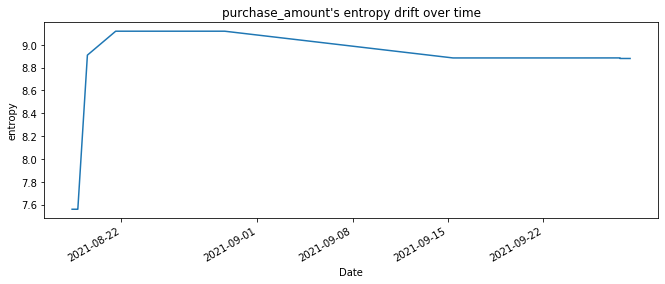

In [16]:
feature_name = 'purchase_amount'
analysis_data_purchase_amount = feature_monitoring_utils.plot_profiling_data(
    analysis_data, 
    feature_name, 
    ['entropy'], 
    kind='line'
)

**See two statistics (entropy and standardDeviation) for purchase_amount feature**

**Separate plots**

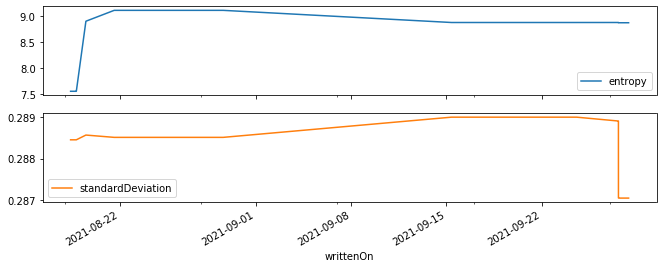

In [17]:
analysis_data_purchase_amount = feature_monitoring_utils.plot_profiling_data(
    analysis_data, 
    feature_name, 
    ['entropy','standardDeviation'],
    multiple_plots=True
)

**Same plot with different scales for each statistic**

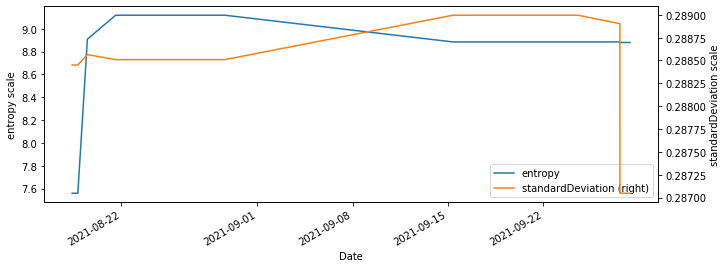

In [18]:
analysis_data_purchase_amount = feature_monitoring_utils.plot_profiling_data(
    analysis_data, 
    feature_name, 
    ['entropy','standardDeviation']
)

**purchase_amount's entropy drift over time using a Bar Plot**

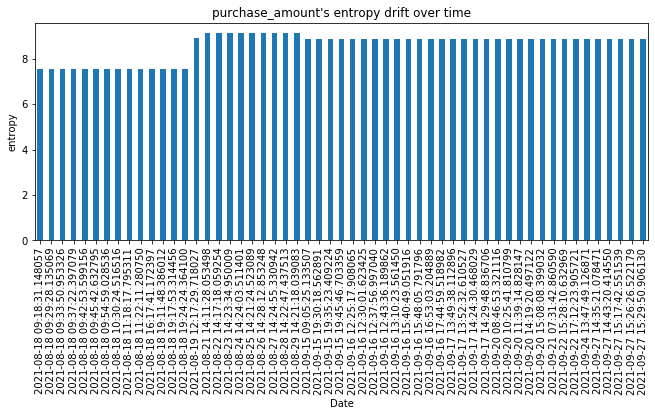

In [9]:
analysis_data_purchase_amount = feature_monitoring_utils.plot_profiling_data(
    analysis_data, 
    feature_name, 
    ['entropy'], 
    kind='bar'
)

## Clean up

**This section ensures you delete all AWS resources that was created as part of this workshop**

In [9]:
# Clean up resources - crawler, DataBrew dataset, and profile job - as well as local analysis folder
analysis_folder_name=response_consolid[4]

response = feature_monitoring_utils.feature_monitoring_cleanup(
    orders_feature_group_name, 
    analysis_folder_name
)

{'ResponseMetadata': {'RequestId': 'cd551d7b-d8b9-491a-a25d-87cd0cf5a1c4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 28 Sep 2021 07:37:44 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'cd551d7b-d8b9-491a-a25d-87cd0cf5a1c4'}, 'RetryAttempts': 0}}
{'ResponseMetadata': {'RequestId': '48131784-155e-483a-9cea-0fc200392d4d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/json', 'content-length': '46', 'connection': 'keep-alive', 'date': 'Tue, 28 Sep 2021 07:37:44 GMT', 'x-amzn-requestid': '48131784-155e-483a-9cea-0fc200392d4d', 'access-control-allow-origin': '*', 'access-control-allow-headers': '*,Content-Type,X-Amz-Date,Authorization,X-Api-Key,X-Amz-Security-Token,X-Amz-Content-Sha256,X-Amz-User-Agent,Date,X-Amz-Target,X-Amzn-Platform-Id,X-Amzn-Trace-Id', 'x-amz-apigw-id': 'GXPrTG_XjoEF2-w=', 'access-control-allow-methods': 'GET,PUT,POST,DELETE,OPTIONS', 'access-control-expose-header